# this is MY TITLE 
Created on Fri Dec  8 12:18:39 2023

@author: samuemu

source: https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html

Yet another largely undocumented script meant to try code in, which will then be 
put into a *"_helper.py"* and *"_runner.py"* script

#### list of abbreviations:

    epo = epoch
    const = constants
    freqs = frequencies
    psd = power spectrum density
    itc = inter-trial coherence
    tfr = time frequency representation

## Imports & User Inputs

In [6]:

import os
from glob import glob
thisDir = os.getcwd()
import mne 
from mne.time_frequency import tfr_morlet
import matplotlib.pyplot as plt
import numpy as np

import FeatureExtraction_constants as const
# import FeatureExtraction_helper as FeatureExtractor

#%% User inputs ###########################################################################################################
subjID = 's001'
dirinput = os.path.join(thisDir[:thisDir.find('Scripts')] + 'Data','SiN','derivatives', 
                        const.pipeID, const.taskID + '_preproc_epoched',subjID)
epo_path = glob(os.path.join(dirinput, str("*"+ const.fifFileEnd)), recursive=True)[0]
# set_path = glob(os.path.join(dirinput, str("*"+ const.setFileEnd)), recursive=True)[0]

## Read epoched data

In [7]:
epo = mne.read_epochs(epo_path)
tmin = epo.times[0]
tmax = epo.times[len(epo.times)-1]

Reading /mnt/smbdir/Projects/Spinco/SINEEG/Data/SiN/derivatives/pipeline-01/task-sin_preproc_epoched/s001/ip_s001_task-sin_avg-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     496.09 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
1152 matching events found
No baseline correction applied
0 projection items activated


## Visualizations

Conventient way to visualise epochs: 
The x-axis is time, and on the y-axis, each row of pixels represents a single epoch, with the colour of each pixel representing signal value (if combine="mean" it's the average of all electrodes)

https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html#plotting-epochs-as-an-image-map

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


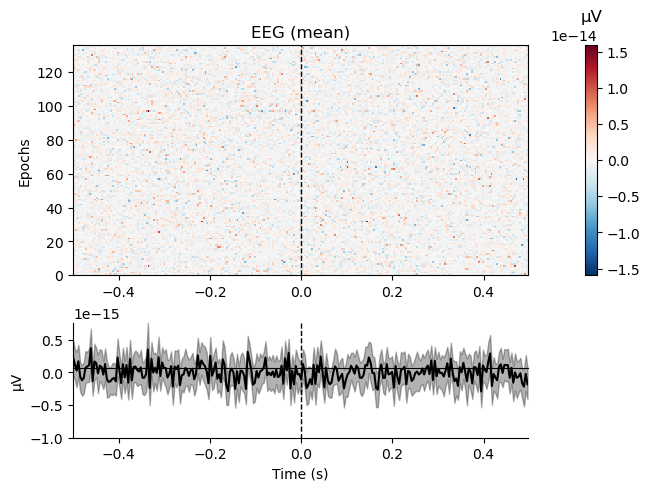

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


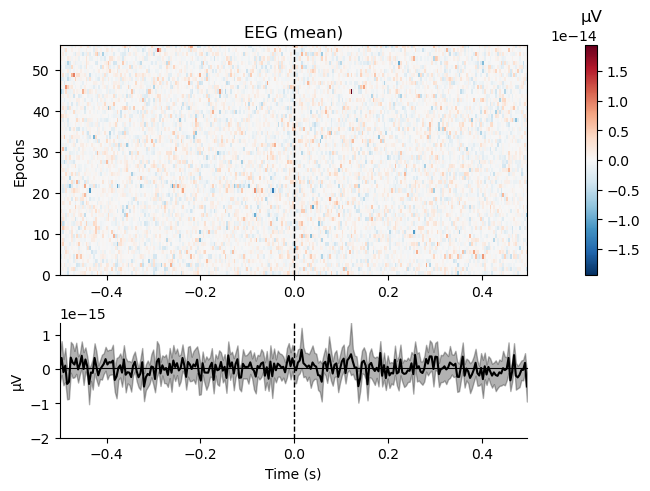

[<Figure size 640x480 with 3 Axes>]

In [8]:
epo['NV/Call/Cor'].plot_image(picks="eeg",combine="mean")
epo['NV/Call/Inc'].plot_image(picks="eeg",combine="mean")

### Plot Power Spectrum densities
https://mne.tools/stable/generated/mne.time_frequency.EpochsSpectrum.html#mne.time_frequency.EpochsSpectrum

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/home/testuser/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


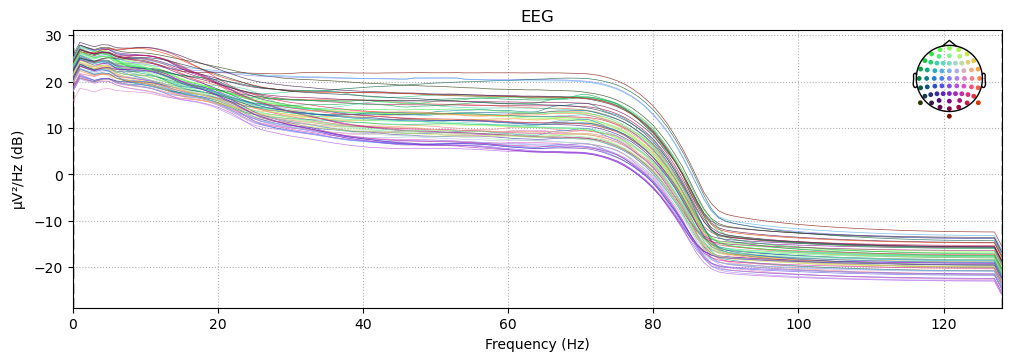

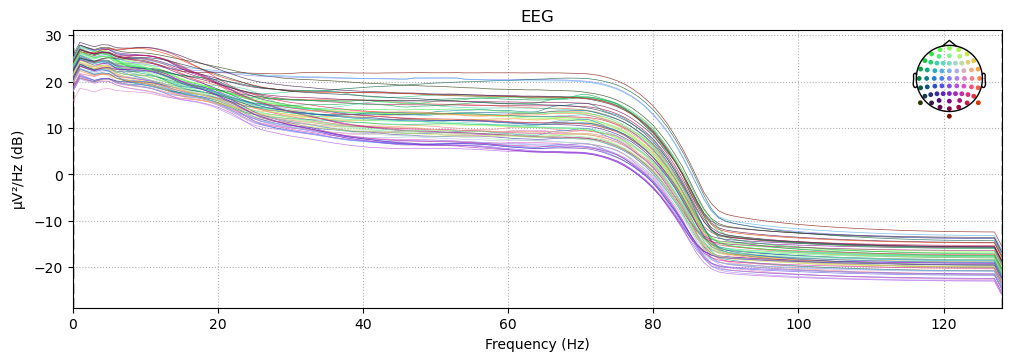

In [9]:
epo.compute_psd().plot()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/home/testuser/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


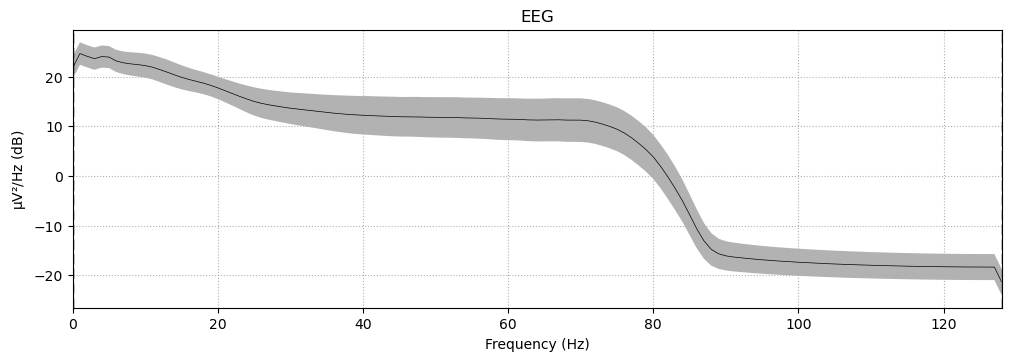

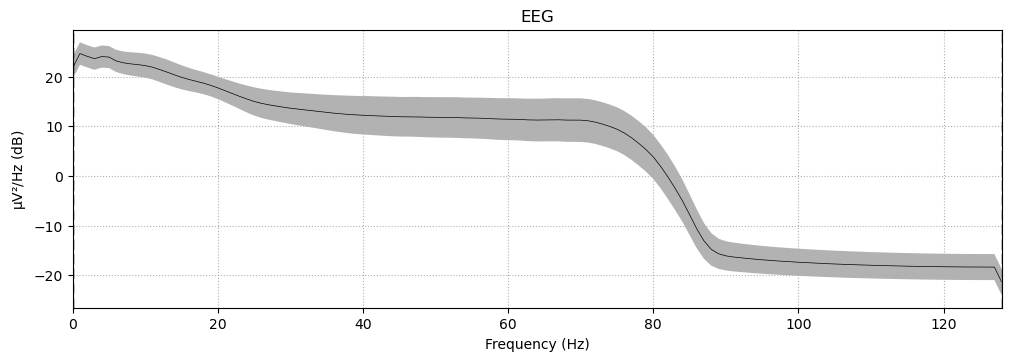

In [10]:
epo.compute_psd().plot(average=True)

    Using multitaper spectrum estimation with 7 DPSS windows


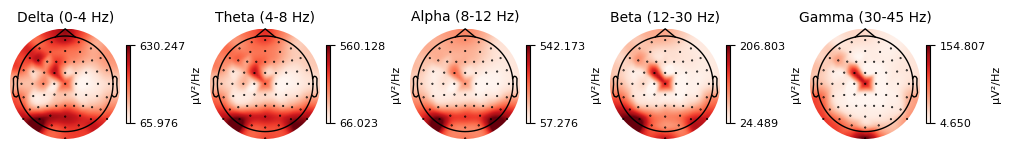

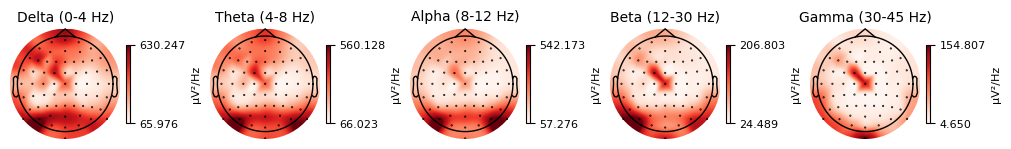

In [11]:
epo.compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)

## Morlet TFR
https://mne.tools/stable/generated/mne.time_frequency.tfr_morlet.html

In [14]:
freqs = np.logspace(*np.log10([1, 48]), num=56) # define frequencies of interest
n_cycles = freqs/2 #
sigma = n_cycles/(2 * np.pi * freqs)

https://mne.tools/stable/generated/mne.time_frequency.morlet.html#mne.time_frequency.morlet

Paraphrased:
The width of a wavelet is determined by Sigma, which is the standard deviation of the Gaussian envelope.
The wavelet extends to +/-5 standard deviations, so the values at tail ends are close to 0.
Sigma is determined by freqs and n_cycles:
    >>> sigma = n_cycles/(2 * np.pi * freqs)

The full-width half-maximum (FWHM) can be determined by:
    >>> fwhm = sigma * 2 * np.sqrt(2 * np.log(2))
    or 
    >>> fwhm = n_cycles * np.sqrt(2 * np.log(2))/(np.pi * freqs)
    
if << n_cycles = freqs / 2 >> then sigma will always be = 1 / (4 * np.pi) = 0.079577

In [15]:
tfr, itc = tfr_morlet(
    epo,
    freqs=const.freqs,
    n_cycles=const.n_cycles,
    use_fft=True,
    decim=3, # reduces data by this factor after convolution to reduce memory usage. May create aliasing artefacts
    n_jobs=None # sequential execution (less memory usage)
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.3s


### Visualisations

https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.plot
to read so I understand the parameters "baseline" and "mode" and know which are appropriate

baseline is the time interval to apply baseline correction (quote from link above)
mode is how the baseline correction is done, e.g. by subtracting the mean of baseline values ('mean')
    or by dividing by the mean of baseline values and taking the log (‘logratio’)

Applying baseline correction (mode: logratio)


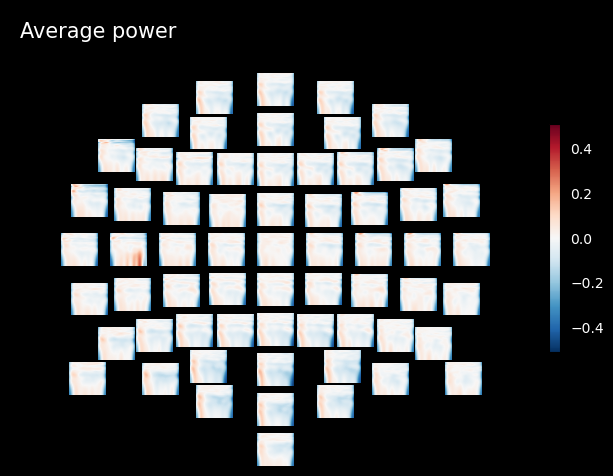

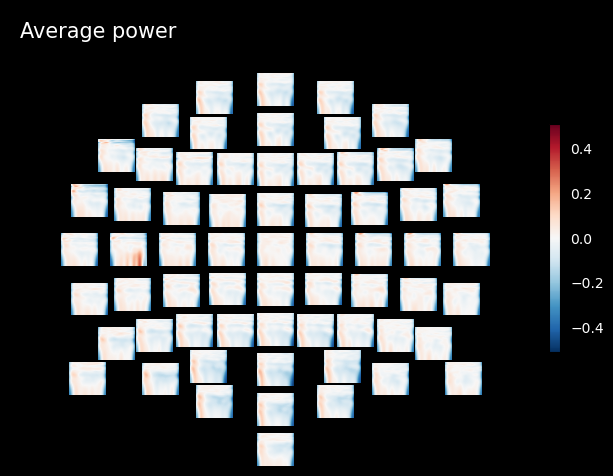

In [17]:
tfr.plot_topo(baseline=(-0.5, 0), mode="logratio", title="Average power")

Applying baseline correction (mode: logratio)


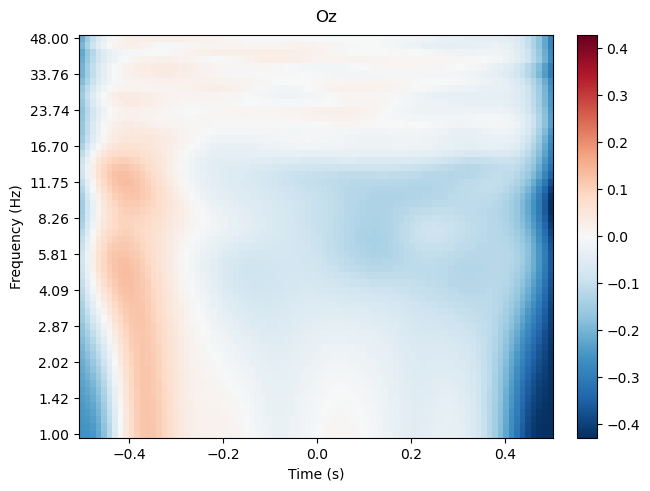

[<Figure size 640x480 with 2 Axes>]

In [18]:
tfr.plot([28], baseline=(-0.5, 0), mode="logratio", title=tfr.ch_names[28])

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


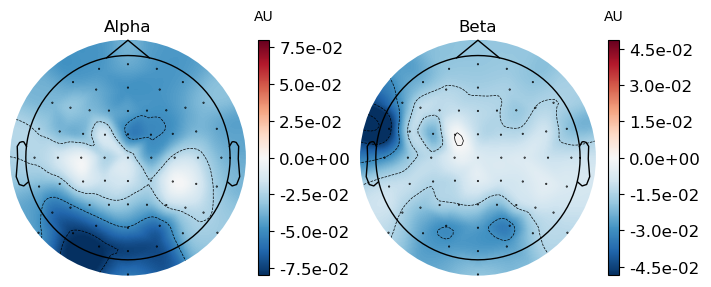

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=tmin, tmax=tmax, baseline=(-0.5, 0), mode="logratio", show=False
)

plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    tfr.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


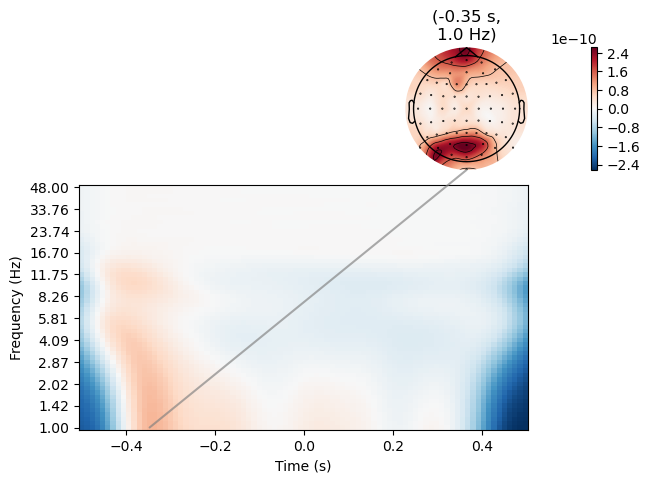

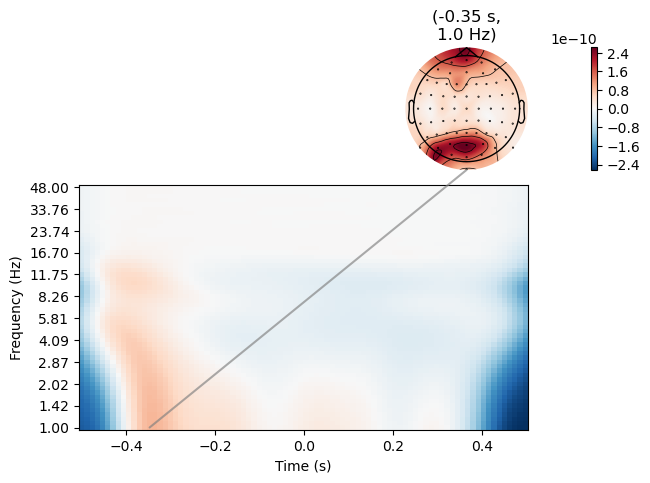

In [20]:
tfr.plot_joint(
    baseline=(-0.5, 0), mode="mean", tmin=tmin, tmax=tmax, 
    # timefreqs=[(-0.3, 10), (0.2, 8)] #this will plot the topomap at X seconds in Y frequency for each tuple (X,Y)
    # if timefreqs == None it will choose the absolute peak of time-frequency and plot the topomap there
    )